In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 727 (delta 11), reused 13 (delta 3), pack-reused 697
Receiving objects: 100% (727/727), 119.73 MiB | 35.81 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=84f195a6d21af8158a15b162e416cc423261b6680920e0e624b1637936a4f1cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5plfml3/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [0]:
from deepul.hw1_helper import *

Dataset 1


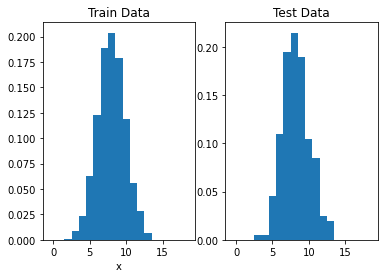

Dataset 2


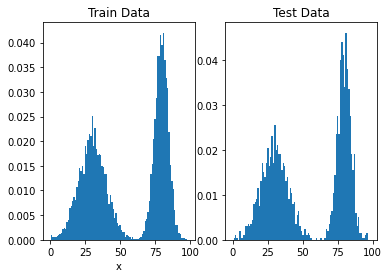

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

In [0]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [0]:
?F.log_softmax

In [0]:
class MixOfLogistics(nn.Module):
  def __init__(self,d,n=4):
    super().__init__()
    self.d = d # number of possible values
    self.n = n # number of mixtures

    # pi needs to sum up to 1 and be probabilities, easier to sample the logits
    self.logits = nn.Parameter(torch.zeros(n), requires_grad=True)
    self.mu = nn.Parameter((torch.arange(n).float() + 1)/(n) * d, requires_grad=True)

    # s has to be positive, sample log s instead
    self.log_s = nn.Parameter(torch.randn(n), requires_grad=True)
    # print(self.logits, self.mu, self.log_s)

  def forward(self, x):
    # d = self.d
    # x = x.float()
    # x = x.unsqueeze(1).repeat(1, self.n) # b x n_mix
    # means, log_scales = self.mu.unsqueeze(0), self.log_s.unsqueeze(0) # 1 x n_mix
    # inv_scales = torch.exp(-log_scales)

    # plus_in = inv_scales * (x + 0.5 - means)
    # min_in = inv_scales * (x - 0.5 - means)

    # cdf_plus = torch.sigmoid(plus_in) # CDF of logistics at x + 0.5
    # cdf_min = torch.sigmoid(min_in) # CDF of logistics at x - 0.5

    # cdf_delta = cdf_plus - cdf_min # probability of x in bin [x - 0.5, x + 0.5]
    # log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))
    # log_cdf_plus = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)),
    #                                                    min=1e-12))
    # log_cdf_min = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * (d - 1.5 - means)),
    #                                     min=1e-12))

    # x_log_probs = torch.where(x < 0.001, log_cdf_plus,
    #                           torch.where(x > d - 1 - 1e-3,
    #                                       log_cdf_min, log_cdf_delta))
    # pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
    # log_probs = x_log_probs + pi_log_probs
    # return torch.logsumexp(log_probs, dim=1)
    # returns log prob = log sum pi*delta cdf = log sum exp ( (log pi + log delta cdf) )
    # max likelihood or cross entropy loss involves log of prob, may overflow
    # difference between two cdf can be too small
    x = x.float().unsqueeze(1).repeat(1, self.n)

    mu = self.mu.unsqueeze(0).repeat(x.shape[0], 1)
    log_s = self.log_s.unsqueeze(0).repeat(x.shape[0], 1)
    inv_s = torch.exp(-log_s)

    prob = torch.sigmoid( (x + 0.5 - mu) * inv_s ) -\
          torch.sigmoid( (x - 0.5 - mu)* inv_s )
    # uptill now everything is elementwise

    # now calculate the prob for each n, each x, each situation (left tail, mid, right tail)
    # even though of the three prob will be used
    log_prob = torch.log(torch.clamp(prob, min=1e-12))

    log_prob_0 = torch.log(torch.clamp(torch.sigmoid(inv_s * (0.5 - mu)),
                                                       min=1e-12))
    log_prob_d = torch.log(torch.clamp(1 - torch.sigmoid(inv_s * (self.d - 1 - .5 - mu)),
                                        min=1e-12))
    # combine the three
    log_probs_each_logistic = torch.where(x < 0.001, log_prob_0,
                               torch.where(x > self.d - 1 - 0.001,
                                           log_prob_d, log_prob))
    # log pi
    log_pi = F.log_softmax(self.logits, dim=0).squeeze(0).repeat(x.shape[0], 1)

    # summing up all prob * pi from n distributions
    return torch.logsumexp(log_pi + log_probs_each_logistic, dim=1)

  def loss(self, x):
    return - torch.mean(self(x))

  def get_distribution(self):
    with torch.no_grad():
      x = torch.arange(self.d).float().cuda()
      out = self(x).exp().detach().cpu().numpy()
    return out





In [0]:
def train(model, train_loader, test_loader, param):
  train_loss = []
  test_loss = [cal_test_loss(model, test_loader)]
  
  epochs, lr = param['epochs'], param['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for i in range(epochs):
    train_loss.extend(cal_train_loss(model, train_loader, optimizer))
    test_loss.append(cal_test_loss(model, test_loader))
  return train_loss, test_loss



In [0]:
def cal_train_loss(model, train_loader, optimizer):
  model.train()
  train_loss = []

  for x in train_loader:
    x = x.cuda()
    loss = model.loss(x)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss.append(loss.item())
  return train_loss                    
  



In [0]:
def cal_test_loss(model, test_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in test_loader:
      x = x.cuda()
      loss = model.loss(x).item()
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(test_loader.dataset)

  return avg_loss


In [0]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """
  model = MixOfLogistics(d).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_loss, test_loss = train(model, train_loader, test_loader, dict(epochs=20, lr=1e-1))
  distribution = model.get_distribution()
  return train_loss, test_loss, distribution

Final Test Loss: 2.0622


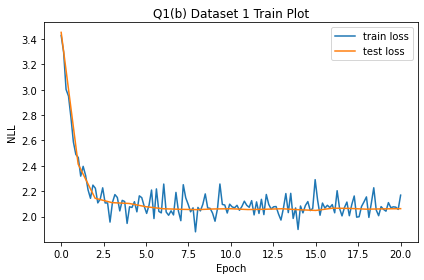

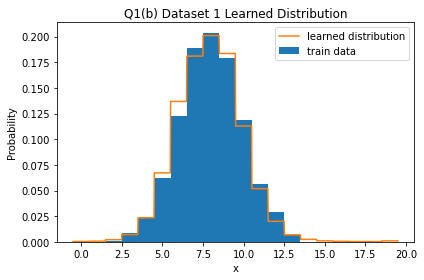

In [94]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 4.0539


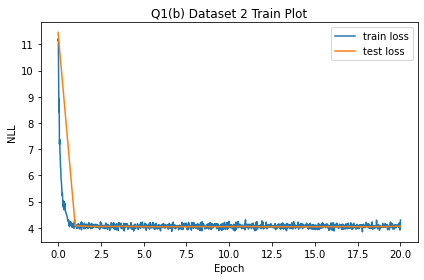

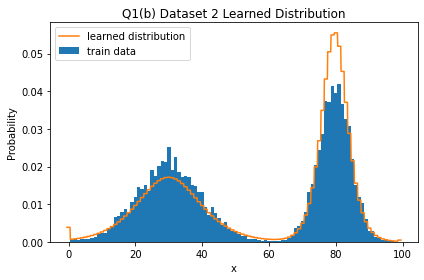

In [95]:
q1_save_results(2, 'b', q1_b)